# LLM Extras

*by mkmenta, https://github.com/mkmenta/llm-workshop*

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mkmenta/llm-workshop/blob/main/EX-llm_extras.ipynb)

En este notebook se añaden ciertos comentarios y conceptos extra que pueden ser interesantes para discutir o reflexionar.

## *Inteligencia* de los modelos

¿Qué modelo es mejor elegir?

- **Benchmarks**: podemos obtener una idea de sus capacidades comparando sus resultados en benchmarks de evaluación. Una buena web comparativa es [Artificial Analysis](https://artificialanalysis.ai/). Sin embargo, los modelos avanzan tan rápido y hay tantos datos sobre los benchmarks en internet, que se considera que estos resultados podrían fácilmente amañarse. Por lo que no debería ser el único modo de diferenciarlos.
- **Arena**: en los LLM Arena personas votan por la mejor respuesta entre modelos, ya que a veces un modelo aunque obtenga un mayor resultado en un benchmark, puede en práctica dar respuestas menos útiles. Una web conocida es [LM Arena](https://lmarena.ai/leaderboard).

¿De qué depende que un modelo sea más o menos capaz? 

Hay varios factores.

### Tamaño de los modelos

El tamaño de los modelos de Deep Learning, y por tanto los LLMs, se miden en el número de parámetros. El número de parámetros hace referencia al "numero de conexiones neuronales" que tiene el modelo. Intuitivamente, a mayor número de conexiones, mayor capacidad de aprendizaje y más inteligente será el modelo (aunque conforme avanza la tecnología, no siempre es así).

Aquí una comparación:

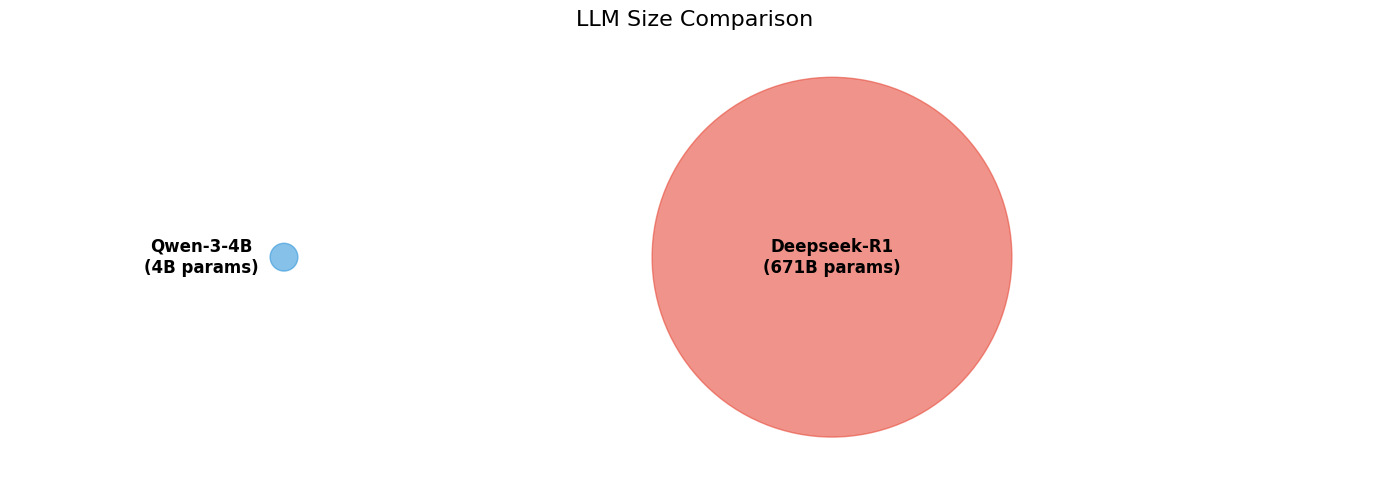

In [1]:
from matplotlib import pyplot as plt
import numpy as np

# Model data
models = ['Qwen-3-4B', 'Deepseek-R1']
params = [4, 671]  # billions of parameters

# Create bubble plot
fig, ax = plt.subplots(figsize=(14, 5))

# Plot bubbles
x = [1, 2]  # x-coordinates for the bubbles (increased spacing)
y = [1, 1]    # y-coordinates for the bubbles

# Use sizes directly proportional to parameter counts
sizes = [p * 100 for p in params]  # No power scaling, just a multiplier

# Create bubbles with size directly proportional to parameter count
bubbles = ax.scatter(x, y, s=sizes, alpha=0.6, c=['#3498db', '#e74c3c'], zorder=2)

# Add labels for each bubble
for i, model in enumerate(models):
    ax.annotate(f"{model}\n({params[i]}B params)", 
                (x[i]-.15 if params[i] < 10 else x[i],
                  y[i]),
                ha='center',
                va='center',
                fontweight='bold',
                fontsize=12,
                color='black')

# Format plot
ax.set_title('LLM Size Comparison', fontsize=16)
ax.set_xlim(0.5, 3)
ax.set_ylim(0.5, 1.5)

# Remove axes and spines
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


### Cuantización

Cada parámetro de la red neuronal se representa como un número. Depende del formato numérico en el que se represente ese parámetro, tendrá más o menos precisión numérica y ocupará más o menos VRAM en nuestra GPU. Por tanto es un balance entre nuestro hardware y la precisión de la ejecución del modelo.

In [2]:
for i, model in enumerate(models):
    print(f"{model}: {params[i]*10**9*4/(1024**3):.1f}GB fp32, "
          f"{params[i]*10**9*2/(1024**3):.1f}GB bf16, "
          f"{params[i]*10**9*1/(1024**3):.1f}GB int8")

Qwen-3-4B: 14.9GB fp32, 7.5GB bf16, 3.7GB int8
Deepseek-R1: 2499.7GB fp32, 1249.8GB bf16, 624.9GB int8


In [3]:
import torch
import math

fp32_info = torch.finfo(torch.float32)
fp32_info_precision_digits = -math.log10(fp32_info.eps)
print(f"torch.float32 -> min: {fp32_info.min}, max: {fp32_info.max}, decimal precision: ~{fp32_info_precision_digits:.2f} digits")

bf16_info = torch.finfo(torch.bfloat16)
bf16_precision_digits = -math.log10(bf16_info.eps)
print(f"torch.bfloat16 -> min: {bf16_info.min}, max: {bf16_info.max}, decimal precision: ~{bf16_precision_digits:.2f} digits")

int8_info = torch.iinfo(torch.int8)
print(f"torch.int8 -> min: {int8_info.min}, max: {int8_info.max}, decimal precision: N/A (integer type)")

torch.float32 -> min: -3.4028234663852886e+38, max: 3.4028234663852886e+38, decimal precision: ~6.92 digits
torch.bfloat16 -> min: -3.3895313892515355e+38, max: 3.3895313892515355e+38, decimal precision: ~2.11 digits
torch.int8 -> min: -128, max: 127, decimal precision: N/A (integer type)


### Entrenamiento y datos

Dependiendo de la forma en la que se haya entrenado (p.e. destilando de un modelo mayor, usando razonamiento), la cantidad de datos y la calidad de estos datos, el modelo acabará con una mayor o menor *inteligencia* en distintos ámbitos.

## Compresión

Una teoría/forma de ver al algoritmo de deep learning es como un algoritmo de compresión, donde los datos de entrenamiento quedan de alguna forma comprimidos de forma muy óptima dentro del modelo. Esta compresión extrema, para que el modelo pueda realizar su tarea de forma óptima, va a forzar a que el LLM encuentre relaciones dentro de esos datos de entrenamiento que no son triviales a simple vista, y este fenómeno es el que hace que los LLMs puedan llegar a ser tan útiles.

Aqui podemos ver un gráfico con el tamaño de Llama 3 y sus datos de entrenamiento

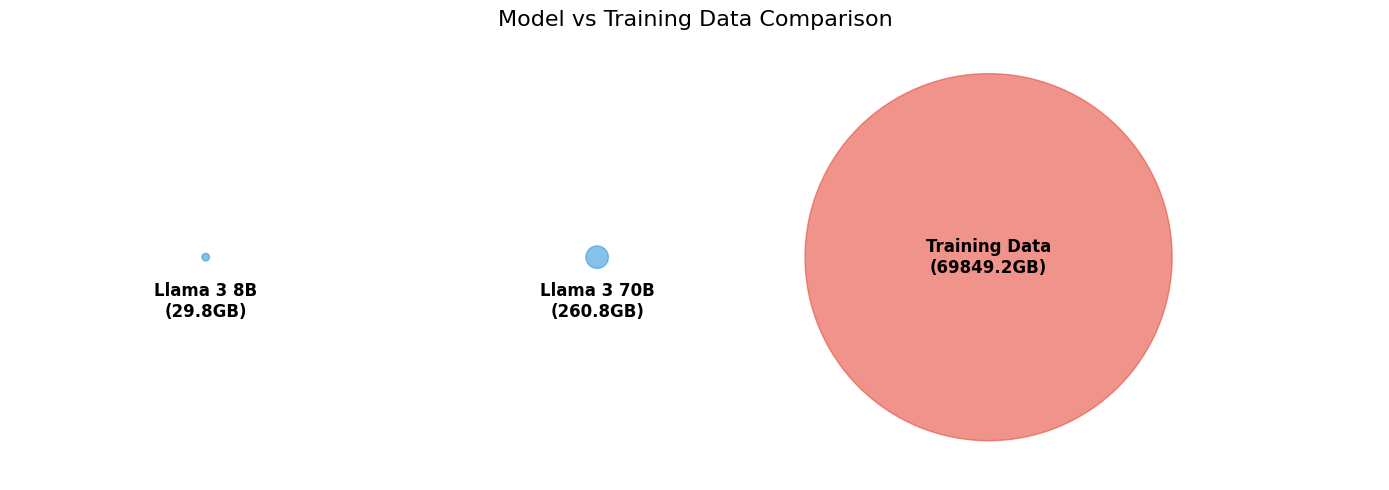

In [4]:
# Storage footprint (bytes) for checkpoints and training data
items = ['Llama 3 8B', 'Llama 3 70B', 'Training Data']
params = [8_000_000_000*4, 
          70_000_000_000*4, 
          15_000_000_000_000*5]  # 15T tokens, 5 bytes/token

# Create bubble plot
fig, ax = plt.subplots(figsize=(14, 5))

# Evenly space categories along the x-axis
x = [1, 2, 3]
y = [1, 1, 1]    # y-coordinates for the bubbles

# Convert byte counts to GiB so bubble areas reflect footprint
sizes = [p / (1024**3) for p in params]  # No power scaling, just a multiplier

# Create bubbles with size directly proportional to parameter count
bubbles = ax.scatter(x, y, s=sizes, alpha=0.6, c=['#3498db','#3498db', '#e74c3c',], zorder=2)

# Add labels for each bubble
for i, model in enumerate(items):
    ax.annotate(f"{model}\n({sizes[i]:.1f}GB)", 
                (x[i], y[i]-.1  if sizes[i] < 1e3 else y[i]),
                ha='center',
                va='center',
                fontweight='bold',
                fontsize=12,
                color='black')

# Format plot
ax.set_title('Model vs Training Data Comparison', fontsize=16)
ax.set_xlim(0.5, 4)
ax.set_ylim(0.5, 1.5)

# Remove axes and spines
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


Sobre este tema y muchas otros conceptos más interesantes y abrumadores recomiendo [esta entrevista](https://www.youtube.com/watch?v=giT0ytynSqg) con Geoffrey Hinton, uno de los *godfather*s de la inteligencia artificial y premio Turing. 

## El camino hacia la AGI

En 2024 [Bloomberg](https://www.bloomberg.com/news/articles/2024-07-11/openai-sets-levels-to-track-progress-toward-superintelligent-ai) escribió sobre los 5 niveles que OpenAI consideraba necesario superar para llegar a la Artificial General Intelligence. Estos niveles eran:

1. Conversational AI: que sean capaces de comunicarse en lenguaje natural como humanos.
2. Reasoning AI: que sea capaz de razonar de forma lógica sus respuestas.
3. AI Agents: AI que sea capaz de interactuar con su entorno autónomamente.
4. Innovative AI: AI que sea capaz de descubrir verdaderas innovaciones de forma autónoma.
5. Organizational AI: AI que sea capaz de realizar el trabajo de una organización entera.

Estos niveles sirven para ver de forma orientativa en qué lugar estamos con respecto a lo que OpenAI esperaba.